# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a picture of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### Get our workspace ready

* Import TensorFlow
* Import TensorFlowHub
* Make sure we're using GPU.

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version', hub.__version__)

# Check for GPU availability
print('GPU', 'Available' if tf.config.list_physical_devices('GPU') else 'Not Available')

TF version: 2.1.0
TF Hub version 0.8.0
GPU Available


 ### Getting our data ready (turning into Tensors)
    
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d11ef31e3d37fd218db0fcc76e416241  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


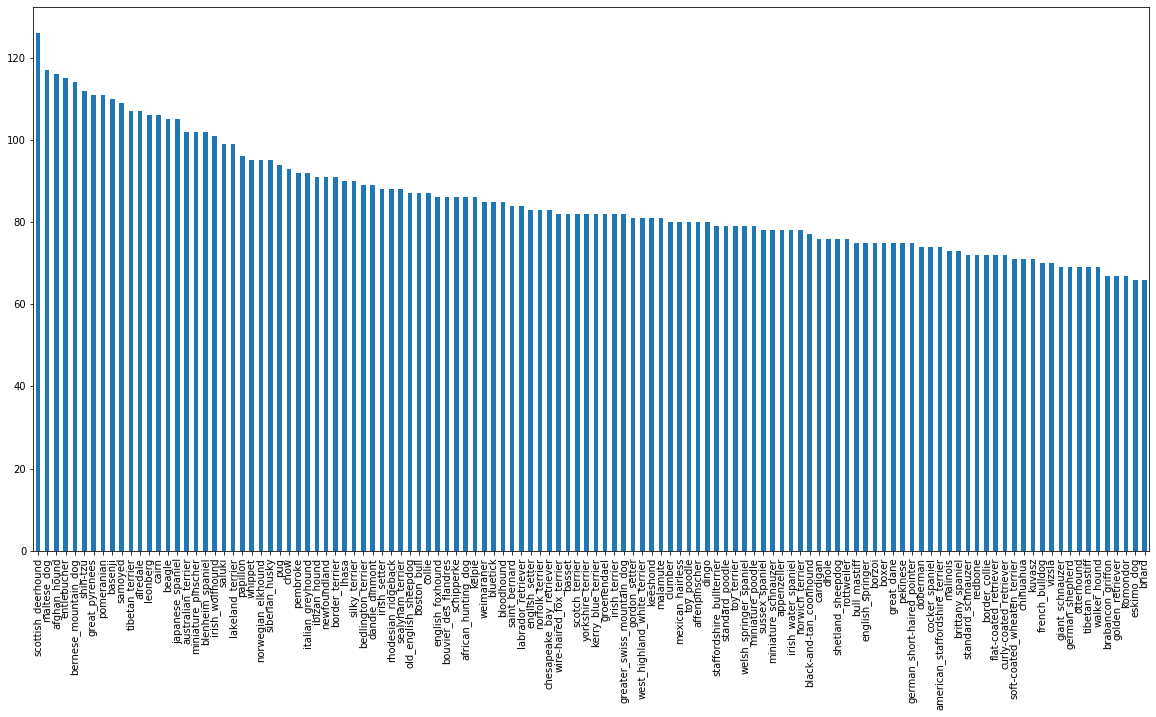

In [3]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize = (20, 10));

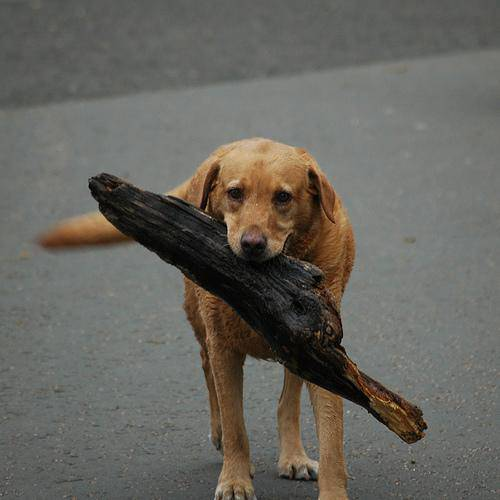

In [4]:
# Let's view an image
from IPython.display import Image
Image('data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')

### Getting images and their labels

Let's get a list of our image file pathnames.

In [5]:
# Create pathnames from image IDs
filenames = ['data/train/' + fname + '.jpg' for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [6]:
# Check whether the number of filenames match the actual number of images
import os
if len(os.listdir('data/train/')) == len(filenames):
    print('Filenames match actual amount of files.')
else:
    print("Filenames don't match the actual number of files")

Filenames match actual amount of files.


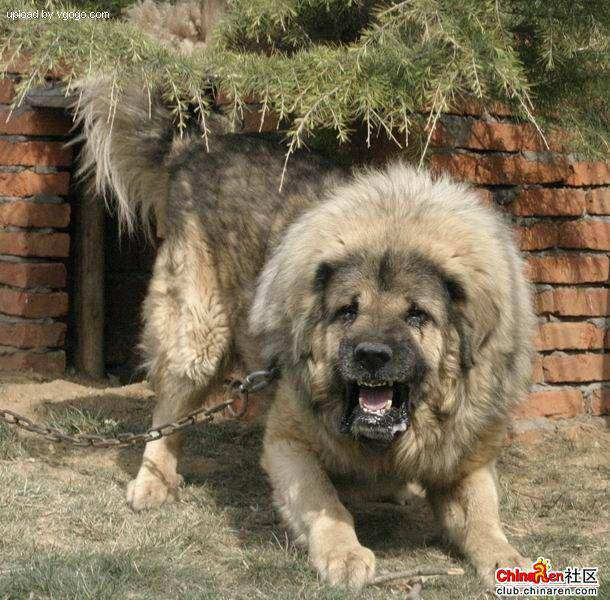

In [7]:
# One more check
Image(filenames[9000])

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [8]:
import numpy as np
labels = labels_csv['breed']
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [9]:
len(labels)

10222

In [10]:
# See if number of labels match the number of filenames
if len(labels) == len(filenames):
    print('Number of labels match the number of filenames')
else:
    print('Number of labels do not match the number of filenames, check data directories')

Number of labels match the number of filenames


In [11]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [12]:
# Turn label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [13]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with validation set, we're going to create our own.

In [14]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [15]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and incerese as needed.

In [16]:
# Set number of images to use for experimenting
NUM_IMAGE = 1000 #@param {type: 'slider', min : 1000, max : 10000, steps : 1000}
NUM_IMAGE2 = 2000
NUM_IMAGE3 = 3000
NUM_IMAGE4 = 4000
NUM_IMAGE5 = 5000
NUM_IMAGE6 = 6000
NUM_IMAGE7 = 7000
NUM_IMAGE8 = 8000
NUM_IMAGE9 = 9000
NUM_IMAGE10 = 10000

In [17]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGE],
                                                  y[:NUM_IMAGE],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [18]:
# Let's have a gaze at the training data
X_train[:5], y_train[:5]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a fucntion which does a few thing:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it into a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values form 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [19]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [20]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [21]:
# Turn image into Tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

In [22]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
    '''
    Takes an image filepath and turn the image into a Tensor.
    '''
    # Read in an image file
    image = tf.io.read_file(image_path)
    
    # Turn the jpg image into numerical Tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels = 3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])
    
    return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the default BATCH_SIZE) images at a time (You can maually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like : `(image, label)`.

In [23]:
# Create a simple functions to return a tuple (image, label)
def get_image_label(image_path, label):
    '''
    Takes an image file path and the associated label,
    processes the image and return a type of (image, label)
    '''
    image = process_image(image_path)
    return image, label

In [24]:
# Demo of the above
(process_image(X[42], tf.constant(y[42])))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

Now we've got a way to turn our data into Tensors in the form of `(image, label`, let's make a function to turn all of our data `(X, y)` into batches.

In [25]:
# Define the batch size, 32 is default
BATCH_SIZE = 32

# Create a function to turn our data into batches.
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    '''
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    '''
    # If the data is test_data, we won't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is valid dataset, we don't need to shuffle
    elif valid_data:
        print('Creating validation Data Batches...')
        data =  tf.data.Dataset.from_tensor_slices((tf.constant(X), # Filepaths
                                                    tf.constant(y))) # Labels
        
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print('Creating training data batches...')
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling after mapping.
        data = data.shuffle(buffer_size = len(X))
        
        # Create (image, label) tuples (this also turn the image path into a preprocessed image)
        data = data.map(get_image_label)
        
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch
        

In [26]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation Data Batches...


In [27]:
# Checking out the different attributes of our data
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is not in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [28]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    '''
    Displays a plot of 25 images and their labels from a data batch.
    '''
    # Setup the figure
    plt.figure(figsize = (10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn off the grid lines
        plt.axis('off')
        

In [29]:
train_images, train_labels = next(train_data.as_numpy_iterator())
val_images, val_labels = next(val_data.as_numpy_iterator())

In [30]:
train_images, train_labels

(array([[[[0.6030087 , 0.5245773 , 0.5310199 ],
          [0.6064176 , 0.53582937, 0.5347089 ],
          [0.75735545, 0.69601095, 0.67108095],
          ...,
          [0.05910382, 0.00420185, 0.00336148],
          [0.04901914, 0.00140022, 0.00112017],
          [0.06597871, 0.01667906, 0.01415807]],
 
         [[0.5797494 , 0.50131804, 0.50776064],
          [0.60703534, 0.5364471 , 0.53532666],
          [0.76410073, 0.7027561 , 0.67782617],
          ...,
          [0.0564903 , 0.00420185, 0.00336148],
          [0.05266066, 0.00140022, 0.00112017],
          [0.07493226, 0.02444461, 0.02192362]],
 
         [[0.5664941 , 0.48806274, 0.49450532],
          [0.6186225 , 0.54803425, 0.5469138 ],
          [0.7846164 , 0.72327185, 0.69834185],
          ...,
          [0.05602262, 0.00420185, 0.00336148],
          [0.05659481, 0.00169284, 0.00112017],
          [0.09051098, 0.03560901, 0.03297547]],
 
         ...,
 
         [[0.20779045, 0.274142  , 0.314303  ],
          [0.19242

In [31]:
val_images, val_labels

(array([[[[0.29599646, 0.43284872, 0.3056691 ],
          [0.26635826, 0.32996926, 0.22846507],
          [0.31428418, 0.27701408, 0.22934894],
          ...,
          [0.77614343, 0.82320225, 0.8101595 ],
          [0.81291157, 0.8285351 , 0.8406944 ],
          [0.8209297 , 0.8263737 , 0.8423668 ]],
 
         [[0.2344871 , 0.31603682, 0.19543913],
          [0.3414841 , 0.36560842, 0.27241898],
          [0.45016077, 0.40117094, 0.33964607],
          ...,
          [0.7663987 , 0.8134138 , 0.81350833],
          [0.7304248 , 0.75012016, 0.76590735],
          [0.74518913, 0.76002574, 0.7830809 ]],
 
         [[0.30157745, 0.3082587 , 0.21018331],
          [0.2905954 , 0.27066195, 0.18401104],
          [0.4138316 , 0.36170745, 0.2964005 ],
          ...,
          [0.79871625, 0.8418535 , 0.8606443 ],
          [0.7957738 , 0.82859945, 0.8605655 ],
          [0.75181633, 0.77904975, 0.8155256 ]],
 
         ...,
 
         [[0.9746779 , 0.9878955 , 0.9342279 ],
          [0.99153

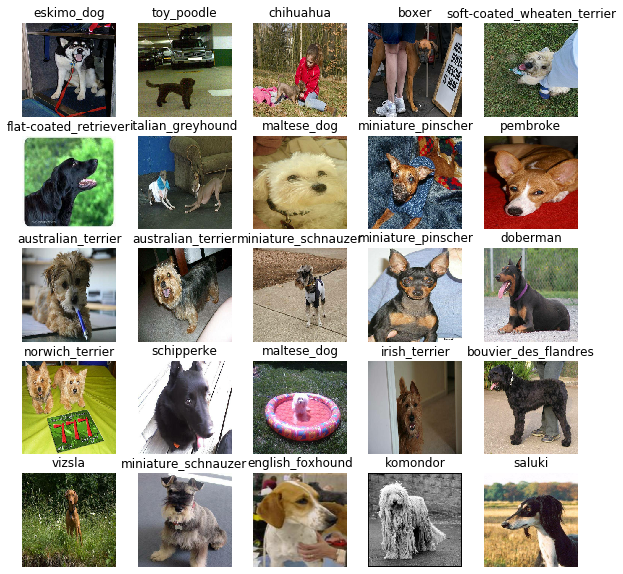

In [32]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

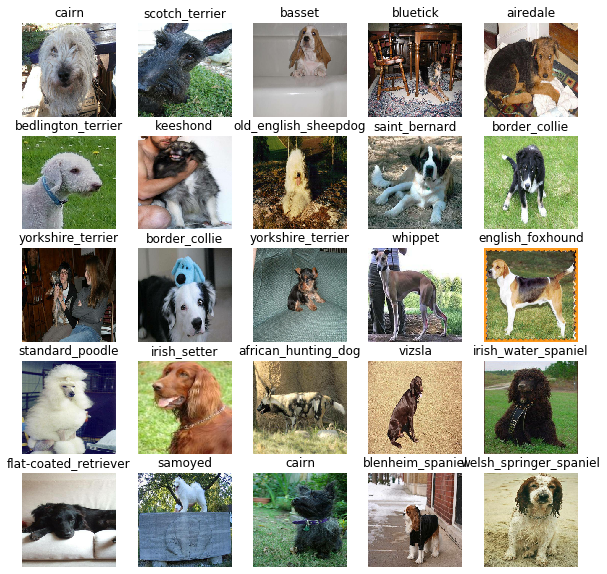

In [33]:
# Visualizing validation batch
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (images labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [65]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras Deep Learning Model!

Knowing this, let's create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and imporved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here : https://www.tensorflow.org/guide/keras/overview

In [73]:
# Create a function which builds a Keras Model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building model with : ', MODEL_URL)
    
    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                             activation = 'softmax') # Layer 2 (output layer)
    ])
    
    # compile the model
    model.compile(
                loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
    )
    
    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [74]:
model = create_model()
model.summary()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_9 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helpful functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [75]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join('data\logs',
                          # make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    )
    return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [77]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [78]:
NUM_EPOCHS = 100
NUM_EPOCHS2 = 200
NUM_EPOCHS3 = 300
NUM_EPOCHS4 = 400
NUM_EPOCHS5 = 500
NUM_EPOCHS6 = 600
NUM_EPOCHS7 = 700
NUM_EPOCHS8 = 800
NUM_EPOCHS9 = 900
NUM_EPOCHS10 = 1000

In [85]:
# Checking to make sure we're still running on a GPU
print('GPU', 'Available' if tf.config.list_physical_devices('GPU') else 'NA')

GPU Available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, the number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model

In [80]:
# Build a function to train and return a trained model
def train_model():
    '''
    Trains a given model and returns the trained version.
    '''
    
    # Create a model
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created
    model.fit(x = train_data,
              epochs = NUM_EPOCHS,
              validation_data = val_data,
              validation_freq = 1,
              callbacks = [tensorboard, early_stopping])
    
    # Return the fitted model
    return model

In [81]:
# Fit the model to the data
model = train_model()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 26s 1s/step - loss: 4.5999 - accuracy: 0.0887 - val_loss: 3.4151 - val_accuracy: 0.2300
Epoch 2/100
25/25 [==============================] - 20s 798ms/step - loss: 1.6492 - accuracy: 0.6862 - val_loss: 2.1783 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 20s 799ms/step - loss: 0.5849 - accuracy: 0.9250 - val_loss: 1.6835 - val_accuracy: 0.5900
Epoch 4/100
25/25 [==============================] - 20s 801ms/step - loss: 0.2534 - accuracy: 0.9912 - val_loss: 1.4782 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 20s 798ms/step - loss: 0.1476 - accuracy: 0.9987 - val_loss: 1.4030 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 20s 798ms/step - loss: 0.0993 - accuracy: 0.9987 - val_loss: 1.3522 - val_accuracy: 0.6400
Epo

## Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directly we created earlier and visualize its contents.

In [86]:
%tensorboard --logdir data/logs

Reusing TensorBoard on port 6006 (pid 9828), started 21:23:11 ago. (Use '!kill 9828' to kill it.)

## Making and evaluating predictions using a trained model

In [87]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 25s 4s/step


array([[4.6078302e-04, 3.5809495e-05, 7.4358960e-04, ..., 1.4784842e-04,
        3.9608854e-05, 2.2868691e-03],
       [1.1086410e-03, 9.6553360e-04, 5.0108666e-03, ..., 2.9831827e-03,
        9.8141085e-04, 8.5155247e-04],
       [4.1448886e-05, 3.2789420e-04, 7.0293296e-05, ..., 5.4710599e-05,
        7.1080794e-05, 2.9870347e-04],
       ...,
       [4.2805973e-06, 3.0588226e-06, 1.3008082e-04, ..., 3.1848929e-05,
        1.0483315e-04, 6.8440917e-05],
       [4.4912845e-03, 6.1077444e-04, 2.3504421e-04, ..., 9.0020325e-04,
        7.6927841e-05, 7.9422006e-03],
       [1.3915981e-04, 1.0533811e-05, 1.3949918e-03, ..., 4.0876684e-03,
        8.8730414e-04, 4.3129148e-05]], dtype=float32)

In [88]:
predictions.shape

(200, 120)

In [89]:
# First prediction
index = 0
print(predictions[index])
print(f'Max value (probability of prediction) : {np.max(predictions[index])}')
print(f'Sum : {np.sum(predictions[index])}')
print(f'Max index : {np.argmax(predictions[index])}')
print(f'Predicted label : {unique_breeds[np.argmax(predictions[index])]}')

[4.60783020e-04 3.58094949e-05 7.43589597e-04 2.30660171e-05
 9.83073551e-05 5.75383383e-05 4.42202836e-02 2.71131727e-03
 2.13418578e-04 1.99377374e-03 5.77063882e-04 3.62163701e-05
 2.21791881e-04 1.88819249e-05 7.76886518e-05 2.28000834e-04
 8.43675589e-05 3.31384361e-01 9.59806675e-06 1.05297346e-04
 1.50445616e-04 4.47958191e-05 3.02652788e-05 1.26811571e-03
 1.69185078e-04 2.16419285e-04 2.76751965e-01 4.02593178e-05
 1.06505649e-04 4.70652623e-04 2.97569437e-04 5.10109356e-04
 1.95788988e-03 1.72564487e-05 2.09072841e-05 2.07968540e-02
 5.06021170e-05 2.98659579e-04 2.87926505e-05 1.04241750e-04
 2.38845998e-04 7.88209800e-05 7.33768029e-05 5.87001559e-05
 1.96355177e-05 1.28575746e-04 1.00716032e-04 5.12524624e-04
 2.84894515e-04 5.25922980e-04 2.04296797e-04 2.35581065e-05
 6.24396416e-05 1.19514429e-04 2.50561243e-05 3.07889495e-05
 6.40668295e-05 1.50280283e-03 2.17448644e-04 6.38151169e-02
 4.67507307e-05 2.22862709e-05 6.02162501e-04 9.49064924e-05
 3.71463044e-04 5.137796

In [96]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to be able to do it as scale.

And it would be even better if we could see image the prediction is being made on!

**NOTE:** Prediction probabilities are also known as confidence levels.

In [97]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    '''
    Turns an array of prediction probabilities into a label.
    '''
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels).

In [98]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    '''
    Takes a batched dataset of (image, label) Tensors and
    returns separate arrays of images and labels.
    '''
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get :
* Prediction labels
* Validation labels
* Validation images

Let's make some function to make these all a bit more visualized.

We'll create a function which :
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [106]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
    '''
    View the prediction, ground truth and image for sample n
    '''
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
    
    # Plot images and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the title depending if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
     
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title('Predicted:{}  Probability{:2.0f}%  True:{}'.format(pred_label,
                                     np.max(pred_prob) * 100,
                                     true_label),
                                      color = color)

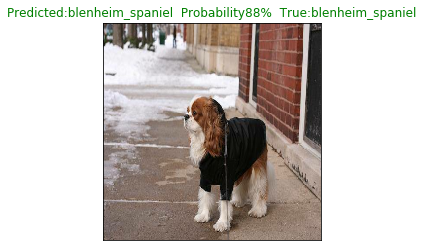

In [140]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 23)

Now we've got one function to visualize our model's top prediction, let's make another to view our model's top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find top 10:
 * Prediction probabilities indexes.
 * Prediction probabilities values.
 * Prediction labels.
* Plot the top 10 prediction probability values and labels, coloring the true label green. 

In [150]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
    '''
    Plots the top 10 highest prediction confidence along with
    the truth label for sample n.
    '''
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color = 'grey')
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels = top_10_pred_labels,
               rotation = 'vertical')
    
    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass

In [151]:
len(predictions)

200

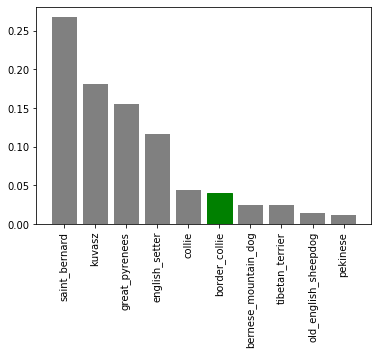

In [157]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 11)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

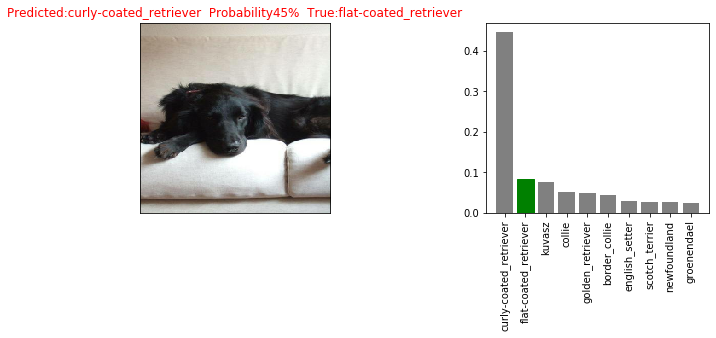

C:\Users\HP\Miniconda3\envs\dogenv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


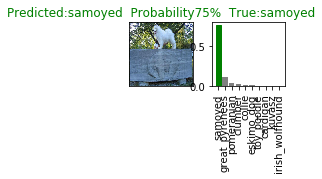

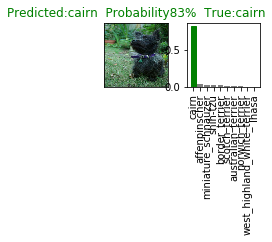

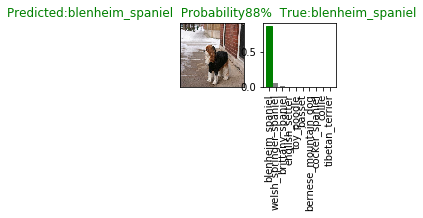

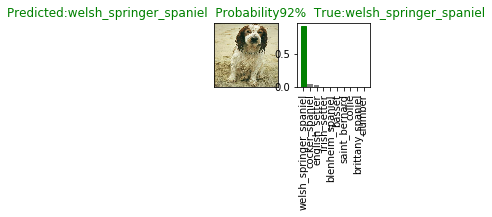

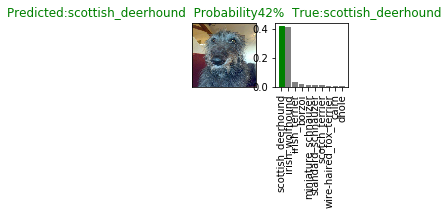

In [187]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize = (10 * num_cols, 4 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities = predictions,
              labels = val_labels,
              images = val_images,
              n = i + i_multiplier)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_pred_conf(prediction_probabilities = predictions,
                   labels = val_labels,
                   n = i + i_multiplier)
    plt.tight_layout(h_pad = 1.0)
    plt.show()

## Saving and reloading a trained model

In [188]:
# Create a function to save a model
def save_model (model, suffix = None):
    '''
    Saves a given model in a models directory and appends 
    a suffix (string).
    '''
    # Create a model directory pathname with current time
    modeldir = os.path.join('models',
                             datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    model_path = modeldir + '-' + suffix + '.h5' # saved format of model
    print(f'Saving the model to : {model_path}....')
    model.save(model_path)
    return model_path

In [193]:
# Crete a function to load a trained model
def load_model(model_path):
    '''
    Loads a saved model from specified path.
    '''
    print(f'Loading saved model from: {model_path}')
    model = tf.keras.models.load_model(model_path,
                                       custom_objects = {
                                       'KerasLayer' :
                                        hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [194]:
# Save our model trained on 1000 images
save_model(model, suffix = '1000-images-mobilenetv2-Adam')

Saving the model to : models\20200425-173404-1000-images-mobilenetv2-Adam.h5....


'models\\20200425-173404-1000-images-mobilenetv2-Adam.h5'

In [195]:
# Load a trained model
loaded_1000_image_model = load_model('models/20200425-173404-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: models/20200425-173404-1000-images-mobilenetv2-Adam.h5


In [196]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 5s 653ms/step - loss: 1.2155 - accuracy: 0.6600


[1.2154583164623805, 0.66]

In [197]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 5s 696ms/step - loss: 1.2155 - accuracy: 0.6600


[1.2154583164623805, 0.66]

# Training  a big dog model (on the full model)

In [198]:
len(X), len(y)

(10222, 10222)

In [199]:
# Create a data batch with full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [200]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [202]:
# Create a model for full model
full_model = create_model()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [204]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                             patience = 3)

## The next cell will take time

In [206]:
# Fit the full model to the full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, 
                            full_model_early_stopping])

Train for 320 steps
Epoch 1/100
320/320 [==============================] - 213s 667ms/step - loss: 1.3290 - accuracy: 0.6718
Epoch 2/100
320/320 [==============================] - 202s 632ms/step - loss: 0.3965 - accuracy: 0.8845
Epoch 3/100
320/320 [==============================] - 202s 631ms/step - loss: 0.2362 - accuracy: 0.9365
Epoch 4/100
320/320 [==============================] - 202s 632ms/step - loss: 0.1535 - accuracy: 0.9639
Epoch 5/100
320/320 [==============================] - 202s 631ms/step - loss: 0.1076 - accuracy: 0.9778
Epoch 6/100
320/320 [==============================] - 202s 632ms/step - loss: 0.0800 - accuracy: 0.9838
Epoch 7/100
320/320 [==============================] - 202s 632ms/step - loss: 0.0575 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 202s 631ms/step - loss: 0.0469 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 202s 632ms/step - loss: 0.0376 - accuracy: 0.9960
Epoch 10/100
320/320 [=============

In [207]:
save_model(full_model, suffix = 'full-image-set-mobilenetv2-Adam')

Saving the model to : models\20200425-185820-full-image-set-mobilenetv2-Adam.h5....


'models\\20200425-185820-full-image-set-mobilenetv2-Adam.h5'

In [209]:
# Loading in the full model
loaded_full_model = load_model('models/20200425-185820-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: models/20200425-185820-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test data set

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data__batches() earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [210]:
# Load test image filenames
test_path = 'data/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [211]:
len(test_filenames)

10357

In [212]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [213]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**NOTE:** Calling predict() on our full model and passing it the test batch will take long time to run (~ 1h). This is because we have to process ~10000+ images and get our model to find patterns in those images and generate predictions based on what it's learned in the training dataset.

In [214]:
# Make prediction on test data  batches using the fully model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose = 1)

324/324 [==============================] - 206s 635ms/step


In [215]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt('data/preds_array.csv', test_predictions, delimiter = ',')

In [216]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt('data/preds_array.csv', delimiter = ',')

In [218]:
test_predictions[:10]

array([[2.28163304e-11, 4.84696484e-12, 1.97825667e-15, ...,
        1.03754760e-13, 7.57590490e-10, 5.09416120e-11],
       [8.68978702e-07, 5.57837666e-07, 3.54411078e-09, ...,
        1.38828150e-11, 5.00150001e-08, 3.76668780e-10],
       [8.43946007e-12, 1.90387638e-07, 7.11968873e-10, ...,
        2.01727303e-07, 4.11096244e-12, 2.34211574e-11],
       ...,
       [5.06181264e-10, 9.45668370e-12, 1.48205823e-11, ...,
        2.39429949e-13, 8.44431458e-13, 9.44709241e-12],
       [1.99080995e-11, 3.25884320e-10, 3.73133247e-10, ...,
        1.03079310e-06, 1.62187785e-09, 6.04244779e-11],
       [4.02836209e-09, 9.58011795e-11, 1.06662301e-11, ...,
        9.42202994e-14, 2.63065221e-12, 9.64154196e-08]])

In [219]:
test_predictions.shape

(10357, 120)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepath of our own images.
* Turn the filepaths into batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [245]:
# Get custom image filepaths
custom_path = 'data/custom/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [246]:
custom_image_paths

['data/custom/me.jpg', 'data/custom/shrish.jpg']

In [247]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [248]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [249]:
custom_preds.shape

(2, 120)

In [250]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever', 'miniature_pinscher']

In [251]:
# Get custom images (our unbatchify() won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

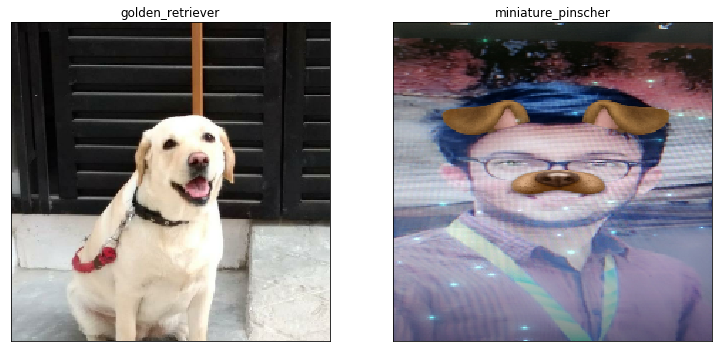

In [252]:
# Check custom image pred0ictions
plt.figure(figsize = (40,20))
for i, image in enumerate (custom_images):
    plt.subplot(1, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)